# Supervised Learning - Classifying posts (Predicting sentiment labels)

In [27]:
### load packages 
import numpy as np 
import pandas as pd

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

## for explainer
from lime import lime_text
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.ensemble import BaggingClassifier

import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import nltk
import string
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.simplefilter("ignore")
from nltk import word_tokenize, corpus
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.corpus import stopwords
stopwords.words('english')
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
sns.set() # use seaborn plotting style
from pactools.grid_search import GridSearchCVProgressBar # to view progressbar for grid search
import sklearn
print(sklearn.__version__)
from time import time


0.24.1


In [28]:
#load data
df=pd.read_csv("processed_sentiment_data.csv").dropna()

#look at data
df

# label encoding 

labels={"Negative": 0, "Neutral": 1, "Positive": 2}

df = df.replace(labels)
df

,Sentiment,lemma_meaningful,processed
0,0,"['app', 'use', 'rh', 'dead']",app use rh dead
1,0,['fud'],fud
2,0,"['amc', 'amc', 'amc', 'low', 'let', 'trade']",amc amc amc low let trade
3,0,"['serious', 'question', 'short', 'ladder', 'at...",serious question short ladder attack
4,0,"['til', 'fucking', 'fuck', 'billionaire', 'fuc...",til fucking fuck billionaire fucker
...,...,...,...
31614,2,"['robinhood', 'let', 'buy', 'gme', 'amc', 'fin...",robinhood let buy gme amc fine opened fidelity...
31615,2,"['help', 'get', 'tendies', 'deepfucking', 'val...",help get tendies deepfucking value part
31616,2,"['dont', 'sell', 'look', 'buy', 'dont', 'let',...",dont sell look buy dont let short win easy
31617,2,"['best', 'yet', 'come', 'got', 'others', 'back...",best yet come got others back let gme amc


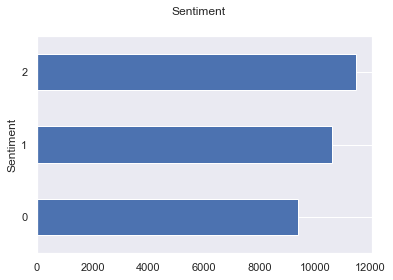

In [29]:
fig, ax = plt.subplots()
fig.suptitle("Sentiment", fontsize=12)
df["Sentiment"].reset_index().groupby("Sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# Train/Test split

! First split data, then vectorize 
https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50

! Use stratified split, bc. we have imbalanced data 

In [30]:
########### VERSION 1 

## split dataset
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=4) 

## get target
y_train = train_data["Sentiment"].values
y_test = test_data["Sentiment"].values

## get text
X_train = train_data["processed"].values
X_test = test_data["processed"].values


In [33]:
### small data set

smallData=df.loc[1:5000]

sX = smallData['processed'] # Collection of documents
sy = smallData['Sentiment'] # Target: The sentiment we want to predict (3 classes)

sX_train, sX_test, sy_train, sy_test = train_test_split(sX, sy, test_size=0.2, stratify=smallData['Sentiment'], random_state=14)

# Piping: Vectorization (using TF-IDF) and multiple classifiers 
https://stackabuse.com/text-classification-with-python-and-scikit-learn/

### MNB

In [34]:
### build a pipeline
tfidf=TfidfVectorizer()

mnb_pipe = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', MultinomialNB()),])

# see paramerts for model 
mnb_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV
mnb_params = {'vectorizer__max_features': [2000, 5000, 7000, 1000],
                  'vectorizer__ngram_range': [(1, 1), (1, 2),(1, 3)],
                  'vectorizer__max_df': (0.5, 0.6, 0.7),
                  'vectorizer__min_df': [3,4],
                  'vectorizer__stop_words': ['english', None],
                  'vectorizer__smooth_idf': [True, False],
                  'vectorizer__use_idf': [True, False],
                  'classifier__fit_prior': [True, False],
                  'classifier__alpha': [0.1, 0.5, 1],} # (1e-2, 1e-3)


mnb_gs = HalvingGridSearchCV(mnb_pipe,mnb_params,cv=5,n_jobs=-1, verbose=1,factor=2)#5-fold, computation will be dispatched on all the CPUs
mnb_gs = mnb_gs.fit(X_train, y_train)

print('Done')



n_iterations: 10
n_required_iterations: 12
n_possible_iterations: 10
min_resources_: 30
max_resources_: 25169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 3456
n_resources: 30
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
----------
iter: 1
n_candidates: 1728
n_resources: 60
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
----------
iter: 2
n_candidates: 864
n_resources: 120
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
----------
iter: 3
n_candidates: 432
n_resources: 240
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
----------
iter: 4
n_candidates: 216
n_resources: 480
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
----------
iter: 5
n_candidates: 108
n_resources: 960
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 6
n_candidates: 54
n_resources: 1920
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 7
n_can

In [33]:

### get the best 
print('Best score on training data:',mnb_gs.score(X_train, y_train))
print('')
print('Best score on testing data:',mnb_gs.score(X_test, y_test))
print('')
print('Best score',mnb_gs.best_score_)
print('')
print('Best parameters',mnb_gs.best_params_)
print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b

# save the best model 
best_mnb=mnb_gs.best_estimator_
mnb_params=mnb_gs.best_params_

print(best_mnb)
print(mnb_params)



## test classifier 
y_pred = best_mnb.predict(X_test)
predicted_prob = best_mnb.predict_proba(X_test)


####################################################### Evaluation 

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred))

Best score on training data: 0.8215980834753615

Best score on testing data: 0.7620250690822619

Best score 0.7311477853266586

Best parameters {'classifier__alpha': 0.5, 'classifier__fit_prior': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': False, 'vectorizer__stop_words': None, 'vectorizer__use_idf': False}

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=5000, min_df=3,
                                 ngram_range=(1, 2), smooth_idf=False,
                                 use_idf=False)),
                ('classifier', MultinomialNB(alpha=0.5))])
{'classifier__alpha': 0.5, 'classifier__fit_prior': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': False, 'vectorizer__stop_words': None, 'vectorizer__use_idf': False}
Accuracy: 0.76
Auc: 0.

In [ ]:
# comapre to other models 

### Logistic regression 

In [15]:
### build a pipeline
lg_pipe = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', LogisticRegression(random_state=0)),])

# see paramerts for model 
lg_pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'classifier', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifier__verbose', 'classifier__warm_start'])

In [26]:
### build a pipeline
lg_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(random_state=0)),])

# see paramerts for model 
lg_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV ###CHANGE###

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
lg_params = {'classifier__penalty': ['l2'],
             'classifier__C': [0.9, 0.8, 0.7],
             'vectorizer__max_df': (0.5, 0.6, 0.7),
             'vectorizer__min_df': [3,4,5],
             'vectorizer__stop_words': ['english', None],
             'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'vectorizer__use_idf': [True, False],
             'classifier__class_weight': [None, 'balanced'],
            }



lg_gs = HalvingGridSearchCV(lg_pipe,lg_params,cv=5,n_jobs=-1, verbose=1, scoring='accuracy', factor=2)#5-fold, computation will be dispatched on all the CPUs
lg_gs = lg_gs.fit(X_train, y_train)

print('Done')


n_iterations: 10
n_required_iterations: 11
n_possible_iterations: 10
min_resources_: 30
max_resources_: 25169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1080
n_resources: 30
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


KeyboardInterrupt: 

In [10]:
### get the best model and params
print('Best score on training data:',lg_gs.score(X_train, y_train))
print('Best score on testing data:',lg_gs.score(X_test, y_test))
print('Best score',lg_gs.best_score_)
print('Best parameters',lg_gs.best_params_)

print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b
# save the best model 
best_lg=lg_gs.best_estimator_
lg_params=lg_gs.best_params_


Best score on training data: 0.8854145973221026
Best score on testing data: 0.8382329572540919
Best score 0.8051954227382503
Best parameters {'classifier__C': 0.8, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 4, 'vectorizer__stop_words': 'english', 'vectorizer__use_idf': True}



# KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

### build a pipeline
knn_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier()),])

# see paramerts for model 
knn_pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'classifier', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'classifier__algorithm', 'classifier__leaf_size', 'classifier__metric', 'classifier__metric_params', 'classifier__n_jobs', 'classifier__n_neighbors', 'classifier__p', 'classifier__weights'])

In [42]:
### build a pipeline
knn_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier()),]) #algorithm='auto'

# see paramerts for model 
knn_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV ###CHANGE###

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
knn_params = {'classifier__n_neighbors': [1,10, 2],
              'classifier__weights': ['uniform', 'distance'],
              'classifier__metric': ['minkowski'],
              'classifier__leaf_size': [20, 40, 1],
              'classifier__p': [1,2],
             'vectorizer__min_df': [4,5],
             'vectorizer__use_idf': [True, False],}


knn_gs = HalvingGridSearchCV(knn_pipe,knn_params,cv=5,n_jobs=-1, verbose=1, scoring='accuracy', factor=2)#5-fold, computation will be dispatched on all the CPUs
knn_gs = knn_gs.fit(X_train, y_train)

print('Done')

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 196
max_resources_: 25169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 144
n_resources: 196
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 72
n_resources: 392
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------
iter: 2
n_candidates: 36
n_resources: 784
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 3
n_candidates: 18
n_resources: 1568
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 4
n_candidates: 9
n_resources: 3136
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 5
n_candidates: 5
n_resources: 6272
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 6
n_candidates: 3
n_resources: 12544
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 7
n_candidates: 2
n_resources: 25

In [47]:
### get the best model and params
print('Best score on training data:',knn_gs.score(X_train, y_train))
print('Best score on testing data:',knn_gs.score(X_test, y_test))
print('Best score',knn_gs.best_score_) 
print('Best parameters',knn_gs.best_params_)

print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b
# save the best model 
best_knn=knn_gs.best_estimator_
knn_params=knn_gs.best_params_

knn_gs.best_params_

Best score on training data: 0.9932853907584728
Best score on testing data: 0.5493405371047195
Best score 0.5718802324091709
Best parameters {'classifier__leaf_size': 1, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 1, 'classifier__p': 2, 'classifier__weights': 'distance', 'vectorizer__min_df': 5, 'vectorizer__use_idf': True}



{'classifier__leaf_size': 1,
 'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 1,
 'classifier__p': 2,
 'classifier__weights': 'distance',
 'vectorizer__min_df': 5,
 'vectorizer__use_idf': True}

### Random Forrest
See exercise 9
https://www.kaggle.com/emanueleamcappella/random-forest-hyperparameters-tuning#4.-Machine-learning scroll to 4. 
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [12]:
### build a pipeline
rf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=14)),])

# see paramerts for model 
rf_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV ###CHANGE###

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
rf_params = {'classifier__max_features': ['auto', 'sqrt', 'log2'],
             'classifier__n_estimators': [80, 90],
             'classifier__max_depth': [3,4],
             'vectorizer__min_df': [4,5],
             'classifier__min_samples_split': [4, 5],            
             'vectorizer__stop_words': ['english', None],
             'vectorizer__use_idf': [True, False],
             'classifier__bootstrap': [False, True],}



rf_gs = HalvingGridSearchCV(rf_pipe,rf_params,cv=5,n_jobs=-1, verbose=1, scoring='accuracy', factor=2)#5-fold, computation will be dispatched on all the CPUs
rf_gs = rf_gs.fit(X_train, y_train)

print('Done')

n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 98
max_resources_: 25169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 384
n_resources: 98
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
----------
iter: 1
n_candidates: 192
n_resources: 196
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 2
n_candidates: 96
n_resources: 392
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 3
n_candidates: 48
n_resources: 784
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 4
n_candidates: 24
n_resources: 1568
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 5
n_candidates: 12
n_resources: 3136
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 6
n_candidates: 6
n_resources: 6272
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 7
n_candidates: 3
n_resource

In [13]:
best_rf=rf_gs.best_estimator_
best_rf

rf_gs.best_params_


{'classifier__bootstrap': True,
 'classifier__max_depth': 4,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 90,
 'vectorizer__min_df': 5,
 'vectorizer__stop_words': 'english',
 'vectorizer__use_idf': False}

In [14]:
### get the best model and params
print('Best score on training data:',rf_gs.score(X_train, y_train))
print('Best score on testing data:',rf_gs.score(X_test, y_test))
print('Best score',rf_gs.best_score_)
print('Best parameters',rf_gs.best_params_)

print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b
# save the best model 
best_rf=rf_gs.best_estimator_
rf_params=rf_gs.best_params_

rf_gs.best_params_

Best score on training data: 0.46016925583058527
Best score on testing data: 0.45097727633878915
Best score 0.4700998979863996
Best parameters {'classifier__bootstrap': True, 'classifier__max_depth': 4, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 90, 'vectorizer__min_df': 5, 'vectorizer__stop_words': 'english', 'vectorizer__use_idf': False}



{'classifier__bootstrap': True,
 'classifier__max_depth': 4,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 90,
 'vectorizer__min_df': 5,
 'vectorizer__stop_words': 'english',
 'vectorizer__use_idf': False}

In [15]:
from sklearn.svm import SVC

### Support Vector Machine 

In [16]:
### build a pipeline
svm_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC(random_state=2)),])

# see paramerts for model 
svm_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV ###CHANGE###

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
svm_params = {'classifier__gamma': ['scale'],
             'vectorizer__max_df': (0.4, 0.5),
             'vectorizer__min_df': [4,5],         
             'vectorizer__stop_words': ['english', None],
             'vectorizer__use_idf': [True, False], 
             'classifier__kernel': ['poly', 'rbf', 'sigmoid'],}
 
    

svm_gs = HalvingGridSearchCV(svm_pipe,svm_params,cv=5,n_jobs=-1, verbose=1, scoring='accuracy', factor=2)#5-fold, computation will be dispatched on all the CPUs
svm_gs = svm_gs.fit(X_train, y_train)

print('Done')

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 786
max_resources_: 25169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 48
n_resources: 786
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 24
n_resources: 1572
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 12
n_resources: 3144
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 6
n_resources: 6288
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 3
n_resources: 12576
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 25152
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Done


In [17]:
### get the best model and params
print('Best score on training data:',svm_gs.score(X_train, y_train))
print('Best score on testing data:',svm_gs.score(X_test, y_test))
print('Best score',svm_gs.best_score_)
print('Best parameters',svm_gs.best_params_)

print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b

# save the best model 
best_svm=svm_gs.best_estimator_
svm_params=svm_gs.best_params_

Best score on training data: 0.9679367475863165
Best score on testing data: 0.8676307007786429
Best score 0.8599944417804171
Best parameters {'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'vectorizer__max_df': 0.4, 'vectorizer__min_df': 4, 'vectorizer__stop_words': None, 'vectorizer__use_idf': True}



### Gradient boosted tree
https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html 

XGBoost classifier
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ (tuning)
https://hackernoon.com/want-a-complete-guide-for-xgboost-model-in-python-using-scikit-learn-sc11f31bq 


In [18]:
### XGBoost Classifier
### build a pipeline
xgb_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', XGBClassifier(random_state=14, verbosity=2)),])

# see paramerts for model 
xgb_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV ###CHANGE###

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
xgb_params = {'classifier__learning_rate': [ 0.07, 0.1, 0.2],
              'classifier__booster': ['dart', 'gbtree'], 
              'classifier__max_depth' : [6,7,8],
              'vectorizer__max_df': (0.5, 0.6, 0.7),
              'vectorizer__min_df': [3,4],
              'classifier__use_label_encoder' : [True, False],
              'vectorizer__use_idf': [True, False],}
 


xgb_gs = HalvingGridSearchCV(xgb_pipe,xgb_params,cv=5,n_jobs=-1, verbose=1, scoring='accuracy', factor=2)#5-fold, computation will be dispatched on all the CPUs
xgb_gs = xgb_gs.fit(X_train, y_train)

print('Done')

n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 98
max_resources_: 25169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 432
n_resources: 98
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [ ]:
### get the best model and params
print('Best score on training data:',xgb_gs.score(X_train, y_train))
print('Best score on testing data:',xgb_gs.score(X_test, y_test))
print('Best score',xgb_gs.best_score_)
print('Best parameters',xgb_gs.best_params_)

print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b
# save the best model 
best_xgb=xgb_gs.best_estimator_
xgb_params=xgb_gs.best_params_

In [ ]:
### Adaboost Classifier
#https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/


### Bagging

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [24]:
### build a pipeline
bag_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', BaggingClassifier(random_state=14)),])

#{'classifier__n_estimators': 100, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 4, 'vectorizer__use_idf': False}

# see paramerts for model 
bag_pipe.get_params().keys()


### define parameters to be tested usign k-fold CV ###CHANGE###

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
bag_params = {'classifier__n_estimators': [100, 200],
             'vectorizer__max_df': (0.5, 0.6, 0.7),
             'vectorizer__min_df': [4,5],
             'vectorizer__use_idf': [True, False],}


# s coring='accuracy', verbose=1

bag_gs = HalvingGridSearchCV(bag_pipe,bag_params,cv=5,n_jobs=-1, verbose=0, factor=2)#5-fold, computation will be dispatched on all the CPUs
bag_gs = bag_gs.fit(X_train, y_train)

print('Done')

KeyboardInterrupt: 

In [23]:
### get the best model and params
print('Best score on training data:',bag_gs.score(X_train, y_train))
print('Best score on testing data:',bag_gs.score(X_test, y_test))
print('Best score',bag_gs.best_score_)
print('Best parameters',bag_gs.best_params_)

print('')

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b
# save the best model 
best_bag=bag_gs.best_estimator_
bag_params=bag_gs.best_params_

AttributeError: 'HalvingGridSearchCV' object has no attribute 'scorer_'

In [22]:
# summarize results
print("Best: %f using %s" % (bag_gs.best_score_, bag_gs.best_params_))
means = bag_gs.cv_results_['mean_test_score']
stds = bag_gs.cv_results_['std_test_score']
params = bag_gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

AttributeError: 'HalvingGridSearchCV' object has no attribute 'best_score_'

# Model comparison


In [ ]:
print('Best svm score:',svm_gs.best_score_,'with model parameters: ', svm_params)
print('')
print('Best mnb score:',mnb_gs.best_score_, 'with model parameters: ', mnb_params)
print('')
print('Best lg score:',lg_gs.best_score_,'with model parameters: ', lg_params)
print('')
print('Best rf score:',rf_gs.best_score_, 'with model parameters: ', rf_params)
print('')
print('Best XGBoost score:',xgb_gs.best_score_, 'with model parameters: ', xgb_params)
print('')
print('Best KNN score:',knn_gs.best_score_, 'with model parameters: ', knn_params)



# OLD STUFF

In [ ]:
### create vectorizer
tfidf = TfidfVectorizer(max_features=3000,ngram_range=(1, 3), min_df=5, stop_words=stopwords.words('english'))

features = tfidf.fit_transform(X_train).toarray()#only fit vestorizer to the training data
vectorized_features = tfidf.fit_transform(X_train)


In [ ]:
### investigating the vocabulary and their tfidf "values"
vocab = pd.DataFrame(vectorized_features[0].T.todense(), index=tfidf.get_feature_names(), columns=["TF-IDF"])
vocab = vocab.sort_values('TF-IDF', ascending=False)
print (vocab.head(25))

# Making a simple model 
https://sanjayasubedi.com.np/machinelearning/nlp/text-classification-with-sklearn/

In [ ]:
# specify the classifier 
mnb = MultinomialNB()
# transform the list of text to tf-idf before passing it to the model
mnb.fit(tfidf.transform(X_train), y_train)
 
# checking accuracy 
 
y_pred = mnb.predict(tfidf.transform(X_test))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


### Using a pipeline to build the same classifier

In [ ]:
##specify the classifier 
mnb = MultinomialNB()### Pipeline for NB

## pipeline
pipe_mnb = Pipeline([("vectorizer", tfidf),  
                           ("classifier", mnb)])
## train classifier
pipe_mnb.fit(X_train, y_train)

## test 
y_pred = pipe_mnb.predict(X_test)
predicted_prob = pipe_mnb.predict_proba(X_test)


### Grid search to finetune hyperparameters
Almost all the classifiers will have various parameters which can be tuned to obtain optimal performance. 

https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

In [ ]:
# see paramerts for model 
pipe_mnb.get_params().keys()

#### Paramter tuning 

https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b


In [ ]:
### define parameters to be tested usign k-fold CV

parameters_mnb = {'vectorizer__max_features': [2000, 3000, 4000],
                  'vectorizer__ngram_range': [(1, 1), (1, 2)],
                  'vectorizer__stop_words': ['english', None],
                  'vectorizer__fit_prior': [True, False],
                  'vectorizer__use_idf': [True, False],
                  'classifier__alpha': [0.1, 0.5, 1]
                 }

gs_mnnb = GridSearchCVProgressBar(pipe_mnb,parameters_mnb,cv=5,n_jobs=-1, verbose=1)#5-fold, computation will be dispatched on all the CPUs
gs_mnnb=gs_mnnb.fit(X_train, y_train)


In [ ]:
### get the best 

print('Best score on training data:',gs_mnnb.score(X_train, y_train))
print('Best score on testing data:',gs_mnnb.score(X_test, y_test))
print('Best score',gs_mnnb.best_score_)
print('Best parameters',gs_mnnb.best_params_)

# interpretation step 5 https://medium.com/@ishan16.d/text-classification-in-python-with-scikit-learn-and-nltk-891aa2d0ac4b


In [ ]:
### set the best params to the model 

#pipe_mnb.set_params(n_jobs=-1)

### Model evaluation 
https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76


In [ ]:
### Evaluation 

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Build an explainer  
https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [ ]:
## select observation
i = 2749 # cahnge to look for different posts/titles 
txt_instance = test_data["processed"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", y_pred[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

# Make a random forrest classifier

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
https://www.kaggle.com/emanueleamcappella/random-forest-hyperparameters-tuning 
https://medium.com/@benfenison/gridsearching-a-random-forest-classifier-fc225609699c
https://www.kaggle.com/pepacz/randomforestclassifier-with-sklearn-pipeline

Documentation 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# specify the classifier
rf_c = RandomForestClassifier()

# make pipeline 
rf_pipe = Pipeline([("scaler", tfidf),  # #StandardScaler()
                    ("rf", rf_c)])

# specify grid search parameters 
rf_params = [
        {'bootstrap': [False, True],
         'n_estimators': [10, 100, 500],
         'max_features': [0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
         'min_samples_leaf': [10, 12, 14]
        },]


# create the GridSearchCV object
rf_gs = GridSearchCVProgressBar(rf_c, rf_params, cv=2,n_jobs=-1, verbose=1,scoring='neg_mean_squared_error')


# fine-tune the hyperparameters
rf_gs=rf_gs.fit(X_train, y_train)

              


In [ ]:
print('Best score on testing data:',gs_mnnb.score(X_test, y_test))
print('Best score',gs_mnnb.best_score_)
print('Best parameters',gs_mnnb.best_params_)# get the best model
print('Best parameters',rf_gs.best_estimator__)
                

### SVC 



In [ ]:
svc_pipe = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

### logisitc regression 
https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5



In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

# Sklearn pipelines to train several models 

Pipelines allow us to add the necessary steps for a model to do its task. In our case, we need to convert the raw texts into vectorized format and then pass it to the model. Pipeline allows us to group these related steps. We can consider a Pipeline object as a model itself i.e. we can call fit, predict functions.

https://sanjayasubedi.com.np/machinelearning/nlp/text-classification-with-sklearn/ 

In [ ]:
#https://sanjayasubedi.com.np/machinelearning/nlp/text-classification-with-sklearn/

# start with the classic
# with either pure counts or tfidf features
sgd = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="modified_huber"))
    ])
sgd_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="modified_huber"))
    ])
 
svc = Pipeline([
        ("count_vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
svc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
   
all_models = [
    ("sgd", sgd),
    ("sgd_tfidf", sgd_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ]
 
unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print(scores)

### Train and evaluate the best model 

In [ ]:
model = svc
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
